In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report,
    confusion_matrix, roc_curve, auc, precision_recall_curve
)

# Load the datasets
fake_df = pd.read_csv('Fake.csv')
true_df = pd.read_csv('True.csv')

# Add labels to distinguish real from fake news
fake_df['label'] = 0  # Fake news
true_df['label'] = 1   # True news

# Merge the datasets
df = pd.concat([fake_df, true_df], ignore_index=True)

In [29]:
# Split dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=0, stratify=df['label'])

# Fit the TF-IDF vectorizer on the training set
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [30]:
# Train the first Decision Tree classifier without depth restriction
dt_full = DecisionTreeClassifier(random_state=0)
dt_full.fit(X_train_tfidf, y_train)
y_pred_full = dt_full.predict(X_test_tfidf)

# Train the second Decision Tree classifier with max_depth=1
dt_shallow = DecisionTreeClassifier(max_depth=1, random_state=0)
dt_shallow.fit(X_train_tfidf, y_train)
y_pred_shallow = dt_shallow.predict(X_test_tfidf)

In [31]:
# Compute evaluation metrics for both models
metrics = {}

for model_name, y_pred in [("Full Decision Tree", y_pred_full), ("Shallow Decision Tree (max_depth=1)", y_pred_shallow)]:
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    metrics[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Confusion Matrix": conf_matrix
    }


    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))

# Convert metrics to a readable format
metrics_df = pd.DataFrame(metrics).T

# Display evaluation metrics
print("Evaluation Metrics:\n", metrics_df)


Classification Report for Full Decision Tree:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4696
           1       1.00      0.99      0.99      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980


Classification Report for Shallow Decision Tree (max_depth=1):

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4696
           1       0.99      1.00      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Evaluation Metrics:
                                      Accuracy Precision    Recall  F1 Score  \
Full Decision Tree                   0.995212  0.996721  0.993231  0.994973   
Shallow Decision Tree (max_depth=1)  0.992094  0.98570

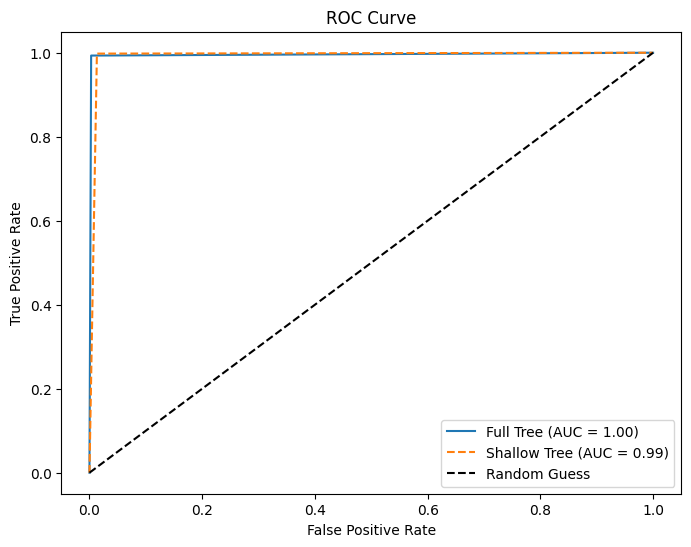

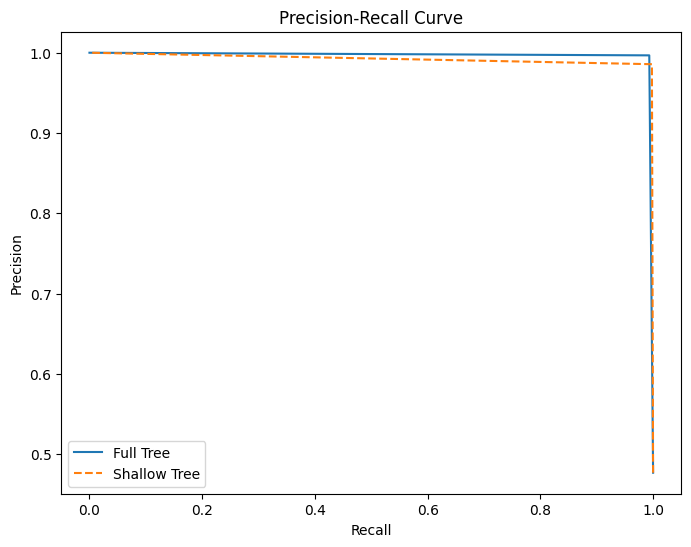

In [32]:
# Compute probabilities for ROC and Precision-Recall curves
y_scores_full = dt_full.predict_proba(X_test_tfidf)[:, 1]
y_scores_shallow = dt_shallow.predict_proba(X_test_tfidf)[:, 1]

# ROC Curve
fpr_full, tpr_full, _ = roc_curve(y_test, y_scores_full)
fpr_shallow, tpr_shallow, _ = roc_curve(y_test, y_scores_shallow)
roc_auc_full = auc(fpr_full, tpr_full)
roc_auc_shallow = auc(fpr_shallow, tpr_shallow)

plt.figure(figsize=(8, 6))
plt.plot(fpr_full, tpr_full, label=f'Full Tree (AUC = {roc_auc_full:.2f})')
plt.plot(fpr_shallow, tpr_shallow, label=f'Shallow Tree (AUC = {roc_auc_shallow:.2f})', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall Curve
precision_full, recall_full, _ = precision_recall_curve(y_test, y_scores_full)
precision_shallow, recall_shallow, _ = precision_recall_curve(y_test, y_scores_shallow)

plt.figure(figsize=(8, 6))
plt.plot(recall_full, precision_full, label='Full Tree')
plt.plot(recall_shallow, precision_shallow, label='Shallow Tree', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
